<a href="https://colab.research.google.com/github/israeljsf95/deep_metric_learning/blob/main/metric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [ ]:
class SiameseMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        img1, label1 = self.mnist_dataset[index]
        should_get_same_class = torch.randint(0, 2, (1,)).item()

        if should_get_same_class:
            while True:
                idx = torch.randint(0, len(self.mnist_dataset), (1,)).item()
                img2, label2 = self.mnist_dataset[idx]
                if label1 == label2:
                    break
        else:
            while True:
                idx = torch.randint(0, len(self.mnist_dataset), (1,)).item()
                img2, label2 = self.mnist_dataset[idx]
                if label1 != label2:
                    break

        return img1, img2, torch.tensor(int(label1 == label2), dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_dataset)



class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            label * torch.pow(euclidean_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# Lendo os Dados

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
siamese_dataset = SiameseMNIST(mnist_dataset)
train_loader = DataLoader(siamese_dataset, shuffle=True, batch_size=32)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.88MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 616kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.41MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
next(iter(train_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [ ]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        # GPU
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.0462
Epoch [2/5], Loss: 0.0182
Epoch [3/5], Loss: 0.0127
Epoch [4/5], Loss: 0.0094
Epoch [5/5], Loss: 0.0073


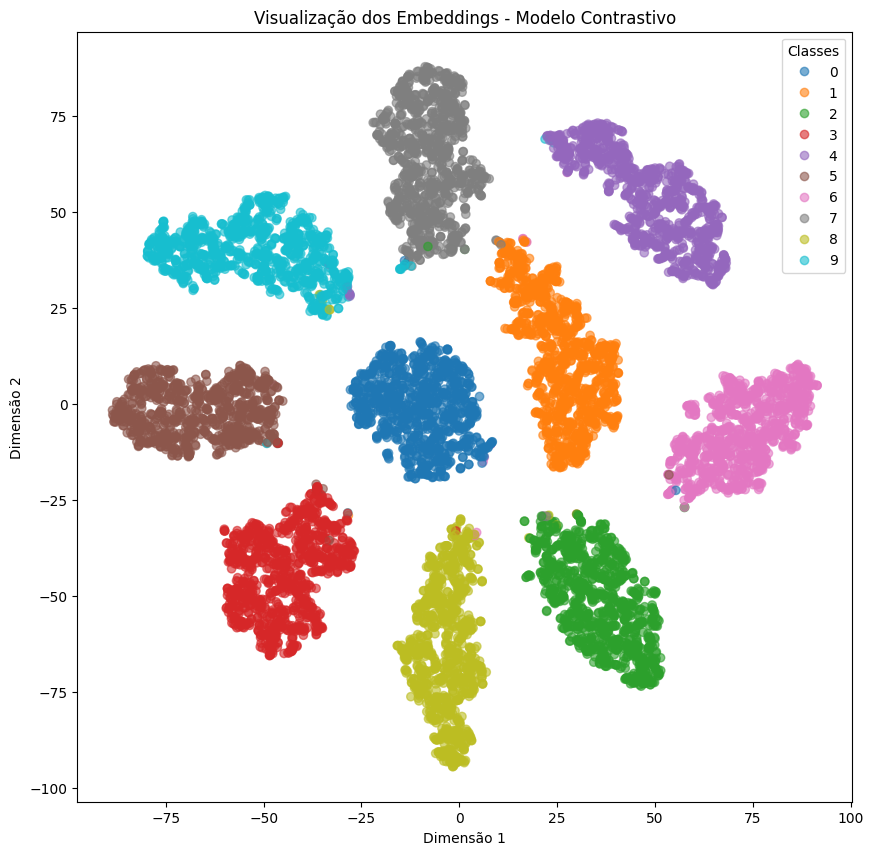

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Carregar o conjunto de teste
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model.eval()

embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model.forward_once(images)
        embeddings.append(outputs.cpu())
        labels_list.append(labels)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels_list)

embeddings_np = embeddings.numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10), title="Classes")
plt.title('Visualização dos Embeddings - Modelo Contrastivo')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()

In [ ]:
class SphereFaceNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SphereFaceNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes, bias=False)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x_norm = nn.functional.normalize(x, dim=1)
        logits = self.fc2(x_norm)
        return logits, x_norm


class AngularSoftmaxLoss(nn.Module):
    def __init__(self, s=30.0, m=1.35):
        super(AngularSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        # Normalizar pesos -> Passo muito importante
        logits_norm = nn.functional.normalize(logits, dim=1)
        # Ajustar logits com margem angular || aqui bem meah pois me lembra SVM
        logits_m = self.s * (logits_norm - self.m)
        loss = self.ce(logits_m, labels)
        return loss

In [ ]:
# o dataset aqui é organizado de maneira diferente pois agora estamos só classificando
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_dataset, shuffle=True, batch_size=64)

In [ ]:
model = SphereFaceNet(num_classes=10).to(device)
criterion = AngularSoftmaxLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, embeddings = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.3074
Epoch [2/5], Loss: 0.0533
Epoch [3/5], Loss: 0.0377
Epoch [4/5], Loss: 0.0282
Epoch [5/5], Loss: 0.0234


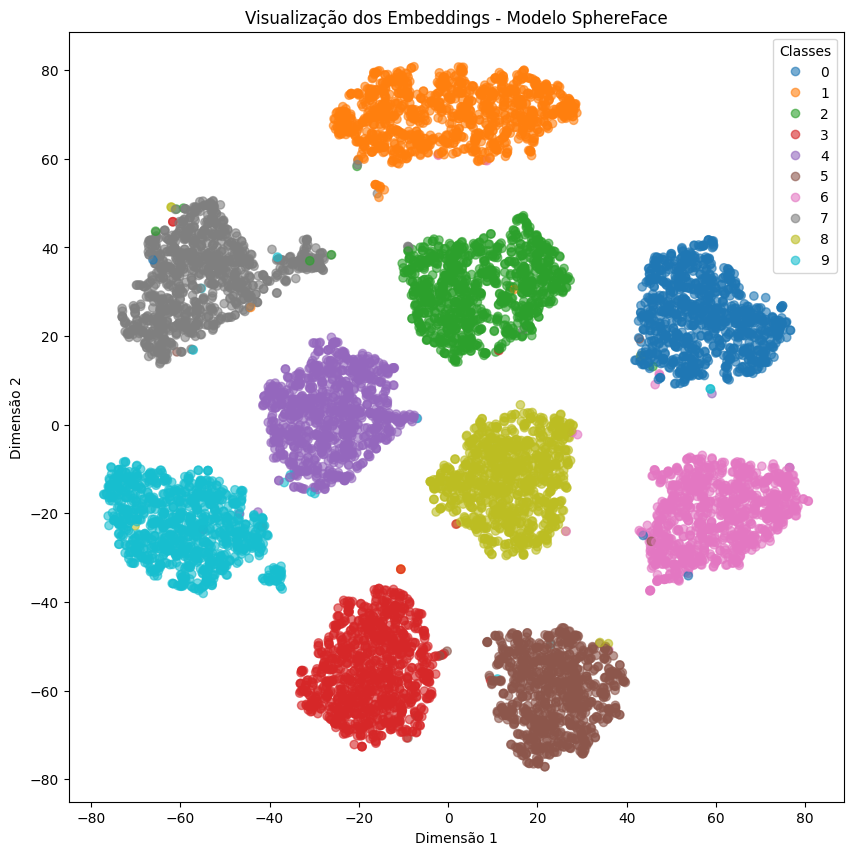

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model.eval()

embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits, outputs = model(images)  # Obter embeddings normalizados
        embeddings.append(outputs.cpu())
        labels_list.append(labels)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels_list)

embeddings_np = embeddings.numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10), title="Classes")
plt.title('Visualização dos Embeddings - Modelo SphereFace')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()